In [4]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

In [5]:
# z = df['message'].value_counts()
# z

In [6]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1', usecols=[0, 1])
df


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
df.columns = ['label', 'message']
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
def extract_additional_features(text):
    urgent_keywords = ['urgent', 'call now', 'claim', 'secure', 'limited offer', 'compromised', 'verify', 'immediately', 'action required']
    financial_keywords = ['free', 'lottery', 'prize', 'money', 'credit', 'loan', 'win', 'cash', 'offer', 'bank', 'account']
    
    urgent_feature = any(keyword in text.lower() for keyword in urgent_keywords)
    financial_feature = any(keyword in text.lower() for keyword in financial_keywords)
    phone_number_feature = bool(re.search(r'\+?\d[\d -]{3,15}\d|\b\d{3,4}[- ]?\d{3,4}\b', text))
    
    return [int(urgent_feature), int(financial_feature), int(phone_number_feature)]

In [10]:
vectorizer = TfidfVectorizer(stop_words='english')  
X = vectorizer.fit_transform(df['message'])
X.shape

(5572, 8404)

In [11]:
additional_features = np.array([extract_additional_features(text) for text in df['message']])

# Combine features
X_combined = hstack([X, additional_features])

In [12]:
y = df['label'].map({'ham': 0, 'spam': 1})
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int64

In [13]:
y.value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [14]:
y = np.array(y)
y.shape

(5572,)

In [15]:
X_combined = hstack([X, additional_features])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [17]:
model = LogisticRegression(max_iter=10000000, random_state=42, class_weight='balanced')
model

LogisticRegression(class_weight='balanced', max_iter=10000000, random_state=42)

In [18]:
model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=10000000, random_state=42)

In [19]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [20]:
f1 = f1_score(y_test, y_pred)
f1

0.9655172413793104

In [21]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[965,   0],
       [ 10, 140]])

In [22]:
acc = accuracy_score(y_test, y_pred)
str(acc*100)+'%'

'99.10313901345292%'

<Axes: >

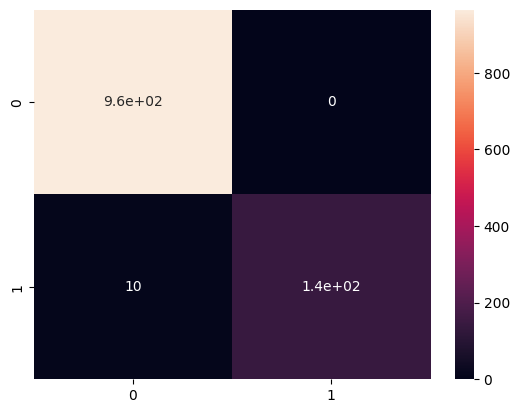

In [23]:
sns.heatmap(cm, annot=True)

In [24]:
import joblib

joblib.dump(model, r'C:\Users\user\Desktop\yolov5\spam message\weight\logistic_model.pkl')
joblib.dump(vectorizer, r'C:\Users\user\Desktop\yolov5\spam message\weight\vectorizer_model.pkl')

['C:\\Users\\user\\Desktop\\yolov5\\spam message\\weight\\vectorizer_model.pkl']

In [25]:
loaded_model = joblib.load(r'C:\Users\user\Desktop\yolov5\spam message\weight\logistic_model.pkl')

In [26]:
vectorizer_path = joblib.load(r'C:\Users\user\Desktop\yolov5\spam message\weight\vectorizer_model.pkl')

In [27]:
user_input =   ["URGENT: Your account has been compromised, call 1234 to secure it."]

In [28]:
user_input_vec = vectorizer_path.transform(user_input)
user_input_additional = np.array([extract_additional_features(text) for text in user_input])
user_input_combined = hstack([user_input_vec, user_input_additional])


In [29]:
probabilities = loaded_model.predict_proba(user_input_combined)[:, 1]
threshold = 0.3

In [30]:
prediction = (probabilities > threshold).astype(int)

In [31]:
if prediction[0] == 0:
    print("Predicted label: ham")
else:
    print("Predicted label: spam")

Predicted label: spam


In [32]:
# user_input_1 = ["Congratulations, you've won a lottery of $10,000! Call now to claim."]
# user_input_2 = ["Hey, how are you doing? Let's catch up sometime soon."]
# user_input_3 = ["URGENT: Your account has been compromised, call 1234 to secure it."]
# user_input_4 = ["Don't forget about our meeting tomorrow at 10 AM."]
# user_input_5 = ["Get a free iPhone now! Click here to claim."]

In [33]:
# inputs = [user_input_1, user_input_2, user_input_3, user_input_4, user_input_5]

In [34]:
# for input_text in inputs:
#     user_input_vec = vectorizer_path.transform(input_text)
#     prediction = loaded_model.predict(user_input_vec)
#     if prediction[0] == 0:
#         print(f"Input: {input_text[0]}\nPredicted label: ham\n")
#     else:
#         print(f"Input: {input_text[0]}\nPredicted label: spam\n")